# Processing a run

In [1]:
%load_ext autoreload
%autoreload 20

In [2]:
# standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# the main package
import pylars

# plot functions
from pylars.plotting.plotwaveforms import *
from pylars.plotting.plotprocessed import *

# specific sub-mudules for waveform and channel processing
from pylars.processing.waveforms import *
from pylars.processing.pulses import *
from pylars.processing.rawprocessor import *

/home/atp/rperes/software/PyLArS/pylars/processing/rawprocessor.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Create processor
process = pylars.processing.rawprocessor.simple_processor(sigma_level=5, 
                                                          baseline_samples=50,
                                                          truncate_wf_left=100,
                                                          truncate_wf_right=600)

In [4]:
#Load the raw data into the processor
data_path = '/disk/gfs_atp/xenoscope/SiPMs/char_campaign/raw_data/run6/data/BV_185K_50_00V/Module0/BV_185K_50_00V_Module_0_0.root'
process.load_raw_data(data_path, 50.0,185, module = 0)

In [5]:
process.raw_data.channels

['wf0', 'wf2', 'wf3', 'wf4', 'wf5', 'wf6']

### Take a look at waveforms

In [6]:
channel_data = process.raw_data.get_channel_data('wf0')
print(f'Found {len(channel_data)} waveforms.')

Found 50000 waveforms.


In [7]:
np.shape(channel_data)

(50000, 500)

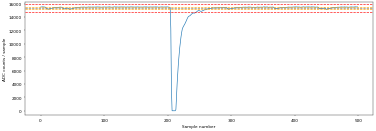

In [8]:
fig, ax = plt.subplots(1,1,figsize = (15,5), dpi = 30)
ax = plot_waveform(channel_data[49999], ax = ax)
plt.show()

### Process by hand

In [9]:
_waveform = np.array(channel_data[7])

baseline = waveform_processing.get_baseline_rough(_waveform, 50) 
std = waveform_processing.get_std_rough(_waveform, 50)
pks = pulse_processing.find_pulses_simple(_waveform, baseline, std, 5)

In [10]:
pks = pulse_processing.find_pulses_simple(np.array(channel_data[0]), baseline, std, 2)

In [11]:
_waveform = np.array(channel_data[0])
print(f'Computed baseline: {baseline}.\nComputed RMS: {std}.')
print(f'Identified pulses: {pks}')

Computed baseline: 15493.5.
Computed RMS: 12.956064217191887.
Identified pulses: [array([59, 60, 61]), array([111]), array([116]), array([147]), array([180, 181]), array([188]), array([205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321]), array([326, 327, 328]), array([333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
    

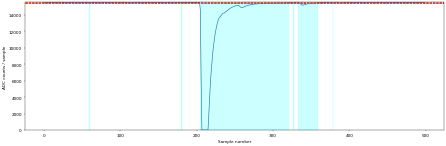

In [12]:
fig, ax = plt.subplots(1,1, figsize = (15,5), dpi = 30)
ax = plot_pulses(_waveform, pks, ax = ax)
plt.tight_layout()
plt.show()

In [13]:
areas, lengths, positions, amplitudes = waveform_processing.process_waveform(np.array(channel_data[7]), 
                                                                             process.baseline_samples, 
                                                                             process.sigma_level)
print(f'Computed areas: {areas}\nComputed amplitudes: {amplitudes}')

Computed areas: [2425685.   37270.   27400.   41555.]
Computed amplitudes: [0.0, 15154.0, 15207.0, 15112.0]


### Full channel

In [14]:
results_ch0 = pd.DataFrame(process.process_channel('wf0'))

Processing module 0 channel wf0:   0%|          | 0/50000 [00:00<?, ?it/s]

In [15]:
results_ch0.head()

,module,channel,wf_number,pulse_number,n_pulses,area,length,position,amplitude
0,0,wf0,0,0,5,2679340.0,103,205,0.0
1,0,wf0,0,1,5,2420.0,5,310,15422.0
2,0,wf0,0,2,5,-0.0,1,320,15489.0
3,0,wf0,0,3,5,30260.0,21,336,15194.0
4,0,wf0,0,4,5,-0.0,1,378,15489.0


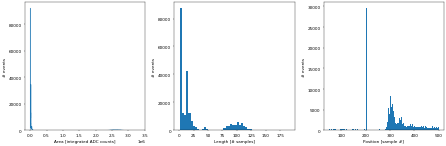

In [16]:
fig, axs = plt.subplots(1,3, figsize = (15,5), dpi = 30)
plot_3hists(results_ch0, axs = axs)
plt.tight_layout()
plt.show()

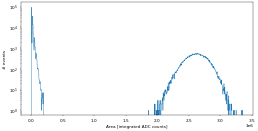

In [17]:
fig, ax = plt.subplots(1,1, figsize = (10,5), dpi = 30)
ax = plot_hist_area(results_ch0,ax = ax)

ax.set_yscale('log')
plt.show()

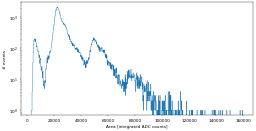

In [18]:
## Is it a fingerplot of afterpulses on the left?
cut_mask = ((results_ch0['length'] > 7) &
            (results_ch0['length'] < 30) &
            (results_ch0['area'] < 0.5e6)
#             (results_ch0['position'] > 280) &
#             (results_ch0['position'] < 400)
           )

fig, ax = plt.subplots(1,1, figsize = (10,5), dpi = 30)
ax = plot_hist_area(results_ch0[cut_mask],ax = ax)

ax.set_yscale('log')
plt.show()